In [30]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zakariyasaleh","key":"770e6c3c3122d89d86489fbc31ce1c75"}'}

In [31]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [32]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d chest_xray

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:24<00:00, 161MB/s]
100% 2.29G/2.29G [00:24<00:00, 99.1MB/s]


In [33]:
!pip install --upgrade tensorflow matplotlib seaborn scikit-learn
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D,SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.utils import class_weight


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
train_dir='/content/chest_xray/chest_xray/train'
categories=['NORMAL','PNEUMONIA']
filepaths=[]
labels=[]
for category in categories:
  folder=os.path.join(train_dir,category)
  for fname in os.listdir(folder):
    filepaths.append(f"{category}/{fname}")
    labels.append(category)
data=pd.DataFrame({'Filename': filepaths,'Label':labels})
data_train,data_valid=train_test_split(data,test_size=0.2,stratify=data['Label'],random_state=42)

In [48]:
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,horizontal_flip=True,brightness_range=[0.9,1.1])
valid_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)


In [49]:
train_data=train_datagen.flow_from_dataframe(dataframe=data_train,directory=train_dir,x_col='Filename',y_col='Label',target_size=(150,150),batch_size=32,seed=42,class_mode='binary',shuffle=True)
valid_data=valid_datagen.flow_from_dataframe(dataframe=data_valid,directory=train_dir,x_col='Filename',y_col='Label',target_size=(150,150),batch_size=32,seed=42,class_mode='binary',shuffle=False)
test_data=test_datagen.flow_from_directory('/content/chest_xray/chest_xray/test',target_size=(150,150),batch_size=32,class_mode='binary',shuffle=False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [50]:
train_labels=train_data.classes
classes=np.unique(train_labels)
cw=class_weight.compute_class_weight(class_weight='balanced',classes=classes,y=train_labels,)
class_weights_dict={int(c): float(w) for c,w in zip(classes,cw)}

In [51]:
#creating the neural network
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(SpatialDropout2D(0.3))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="binary_crossentropy",metrics=["accuracy"])

In [53]:
early_stop=EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-6)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 590ms/step - accuracy: 0.4829 - loss: 0.8550 - val_accuracy: 0.7874 - val_loss: 0.7598 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 549ms/step - accuracy: 0.8668 - loss: 0.5553 - val_accuracy: 0.8707 - val_loss: 0.6345 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 550ms/step - accuracy: 0.8920 - loss: 0.4935 - val_accuracy: 0.9004 - val_loss: 0.5590 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 74s 563ms/step - accuracy: 0.8967 - loss: 0.4643 - val_accuracy: 0.7845 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 559ms/step - accuracy: 0.9167 - loss: 0.4155 - val_accuracy: 0.9358 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 557ms/step - accuracy: 0.9045 - loss: 0.3086 - val_accuracy: 0.9080 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 543ms/step - accuracy: 0.9

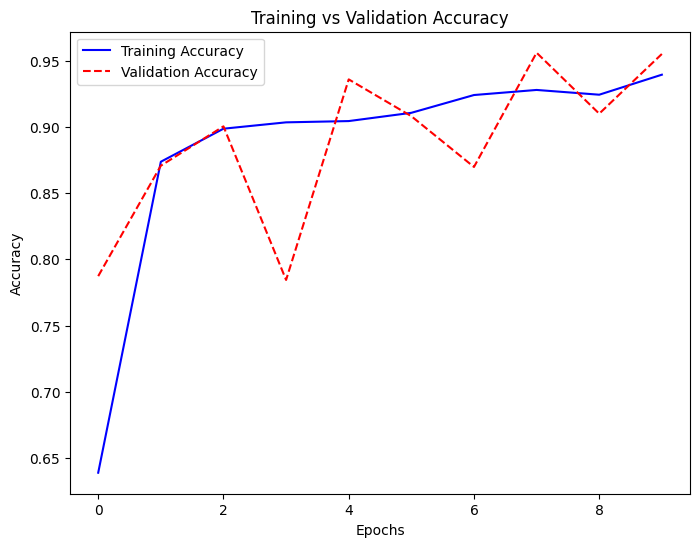

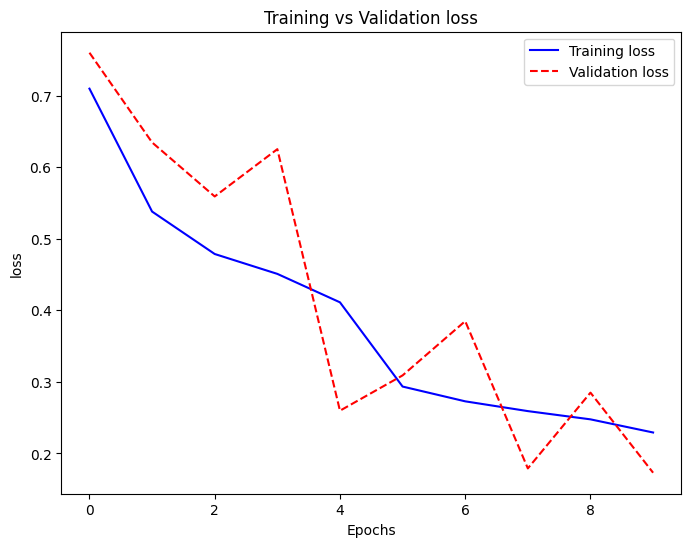

In [54]:
history=model.fit(train_data,epochs=10,validation_data=valid_data,steps_per_epoch=len(train_data),class_weight=class_weights_dict,callbacks=[early_stop,reduce_lr],verbose=1)

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'],'b-',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],'r--',label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'],'b-',label='Training loss')
plt.plot(history.history['val_loss'],'r--',label='Validation loss')
plt.title('Training vs Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.6539 - loss: 0.8602
Test accuracy= 0.807692289352417
Test loss= 0.5327231287956238
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.85      0.81      0.79       624



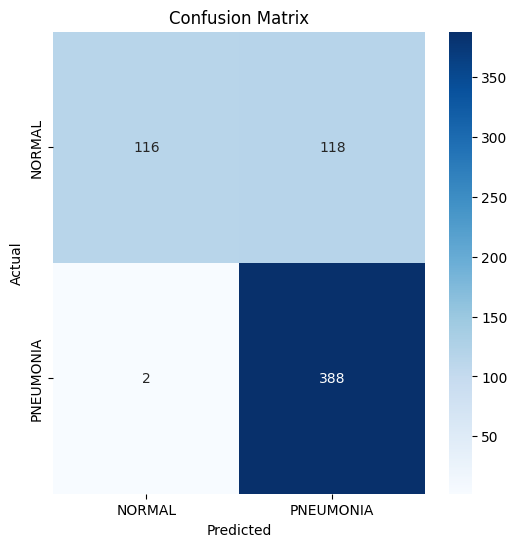

In [55]:
test_loss,test_acc=model.evaluate(test_data)
print("Test accuracy=",test_acc)
print("Test loss=", test_loss)

predictions=model.predict(test_data)
prediction_classes=(predictions>0.5).astype(int)
print(classification_report(test_data.classes,prediction_classes,target_names=list(test_data.class_indices.keys())))

CM=confusion_matrix(test_data.classes,prediction_classes)
plt.figure(figsize=(6,6))
sns.heatmap(CM,annot=True,fmt='g',cmap='Blues',xticklabels=list(test_data.class_indices.keys()),yticklabels=list(test_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
upload=files.upload()

for f in upload.keys():
  img_path=f
  img=image.load_img(img_path,target_size=(150,150),color_mode='grayscale')
  img_array=image.img_to_array(img)/255.0
  img_array=np.expand_dims(img_array,axis=0)
  prediction=model.predict(img_array)
  print(f"prediction for{f}:{'PNEUMONIA' if prediction[0][0]>0.5 else 'Normal'} ")


In [61]:
!mkdir -p /content/my_models
model.save('/content/my_models/my_model.h5')
files.download('/content/my_models/my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>